### look back values for btc_close price
look_back_values = [1, 2, 5, 10, 20]

In [192]:
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
from skopt.space import Real, Categorical, Integer
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator

device = torch.device("cpu")

In [193]:
from skorch.callbacks import Callback
from tqdm import tqdm

class TqdmProgressBar(Callback):
    def on_train_begin(self, net, **kwargs):
        self.epochs = net.max_epochs
        self.pbar = tqdm(total=self.epochs, desc="Training Progress", unit="epoch")

    def on_epoch_end(self, net, **kwargs):
        self.pbar.update(1)  # Increment the progress bar by one epoch

    def on_train_end(self, net, **kwargs):
        self.pbar.close()


In [194]:
train_residuals_df = pd.read_csv("../data/final/train_residuals_df.csv", parse_dates=["Date"], index_col="Date")
test_residuals_df = pd.read_csv("../data/final/test_residuals_df.csv", parse_dates=["Date"], index_col="Date")

train_residual = train_residuals_df["Residuals"]
test_residual = test_residuals_df["Residuals"]

In [195]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.values.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.values.reshape(-1, 1))

# save scaler
joblib.dump(scaler, "../models/residual_scaler.pkl")

['../models/residual_scaler.pkl']

In [196]:
train_residual_scaled = train_residual_scaled.astype(np.float32)
test_residual_scaled = test_residual_scaled.astype(np.float32)

In [197]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.position_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))

    def forward(self, x):
        return self.position_encoding[:, :x.size(1), :]

In [198]:
import torch
import torch.nn as nn

class TemporalFusionTransformer(nn.Module):
    def __init__(self, look_back, num_heads, hidden_dim, feed_forward_dim, dropout_rate,
                 num_layers=1, activation="relu", input_feature_dim=1, n_steps_ahead=1):
        super(TemporalFusionTransformer, self).__init__()
        self.input_projection = nn.Linear(input_feature_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(max_len=look_back, hidden_dim=hidden_dim)
        
        # Define the activation function dynamically
        if activation == "relu":
            self.activation_fn = nn.ReLU()
        elif activation == "gelu":
            self.activation_fn = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Create a stack of transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.ModuleDict({
                "multi_head_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])
        
        # Predict n_steps_ahead for each input sequence
        self.output_layer = nn.Linear(hidden_dim, n_steps_ahead)

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Add positional encoding
        position_encoding = self.positional_encoding(x)
        x = x + position_encoding
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            # Apply multi-head attention
            attn_output, _ = layer["multi_head_attention"](x, x, x)
            x = layer["layer_norm1"](x + attn_output)
            
            # Apply feed-forward network
            ff_output = layer["feed_forward"](x)
            x = layer["layer_norm2"](x + ff_output)

        # Focus on the last time step for forecasting future steps
        x = x[:, -1, :]  
        
        # Pass the entire sequence through the output layer
        outputs = self.output_layer(x)  
        return outputs

### Hyperparameters Tuning using Bayes Optimization

In [199]:
class TemporalFusionTransformerWrapper(nn.Module):
    def __init__(self, look_back, num_heads, head_dim, feed_forward_dim, dropout_rate, num_layers, activation, n_steps_ahead):
        super(TemporalFusionTransformerWrapper, self).__init__()
        self.look_back = look_back
        self.n_steps_ahead = n_steps_ahead
        
        # Initialize the TFT model
        self.model = TemporalFusionTransformer(
            look_back=look_back,
            num_heads=num_heads,
            hidden_dim=num_heads * head_dim,
            feed_forward_dim=feed_forward_dim,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            activation=activation,
            input_feature_dim=1,  # Assuming univariate time series
            n_steps_ahead=n_steps_ahead
        )

    def forward(self, x):
        # # Debug: Print input shape
        # print(f"Wrapper Input shape: {x.shape}")
        
        # Ensure input is 3D: (batch_size, look_back, input_feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(-1)  # Add feature dimension if missing
        
        # # Debug: Print input shape after reshaping
        # print(f"Wrapper Input shape after reshaping: {x.shape}")
        
        # Forward pass through the model
        outputs = self.model(x)  # Shape: (batch_size, n_steps_ahead)
        
        # # Debug: Print model output shape
        # print(f"Model Output shape: {outputs.shape}")
        
        # Reshape output to (batch_size, n_steps_ahead, 1)
        outputs = outputs.squeeze(-1)  # Add feature dimension
        
        # # Debug: Print final output shape
        # print(f"Wrapper Output shape: {outputs.shape}")
        
        return outputs

In [200]:
# Define search space for BayesSearchCV
search_space = {
    "num_heads": Categorical([2, 4, 8]),  
    "head_dim": Categorical([8, 16, 32]),  
    "feed_forward_dim": Categorical([128, 256, 512, 1024]),  
    "dropout_rate": Real(0.1, 0.4),  
    "lr": Real(5e-5, 5e-3, prior="log-uniform"), 
    "batch_size": Categorical([16, 32, 64]), 
    "num_layers": Categorical([1, 2, 3, 4]),
    "activation": Categorical(["relu", "gelu"]),
}

In [201]:
def create_multi_step_dataset(data, look_back, n_steps_ahead=1):
    X, y = [], []
    for i in range(len(data) - look_back - n_steps_ahead + 1):
        X.append(data[i:i + look_back, 0])  # Input sequence
        y.append(data[i + look_back:i + look_back + n_steps_ahead,0])  # Multi-step target
    return np.array(X), np.array(y)

# Prepare training and testing datasets
look_back = 7
n_steps_ahead = 3

# Create train and test datasets
X_train, y_train = create_multi_step_dataset(train_residual_scaled, look_back, n_steps_ahead)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = create_multi_step_dataset(test_residual_scaled, look_back, n_steps_ahead)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(722, 7, 1) (722, 3) (722, 7, 1) (722, 3)


In [202]:
class TFTEstimator(BaseEstimator):
    def __init__(self, look_back=7, num_heads=4, head_dim=16, feed_forward_dim=128,
                 dropout_rate=0.1, lr=0.001, batch_size=32, num_layers=2, activation="relu", n_steps_ahead=3):
        self.look_back = look_back
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.activation = activation
        self.n_steps_ahead = n_steps_ahead
        
        # Initialize the TFT model
        self.model = TemporalFusionTransformerWrapper(
            look_back=look_back,
            num_heads=num_heads,
            head_dim=head_dim,
            feed_forward_dim=feed_forward_dim,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            activation=activation,
            n_steps_ahead=n_steps_ahead
        )

    def fit(self, X, y):
        # Convert inputs to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Training loop
        for epoch in range(10):  # Example: 10 epochs
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = self.model(X_tensor)
        return predictions.numpy()

In [203]:
# Wrap the model with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=TFTEstimator(
        look_back=look_back,
        n_steps_ahead=n_steps_ahead
    ),
    search_spaces=search_space,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the search
bayes_search.fit(X_train, y_train)

# Best parameters and score
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_

print("Best Parameters:", best_params)
print("Best Validation Score:", best_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   0.8s
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   0.9s
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   1.1s
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   1.2s
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   1.3s
Fitting 5 folds for each of 1 c

### Prediction on Test Set

In [207]:
# Make predictions
y_pred = best_model.predict(X_test)

# Inverse transform the predictions
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inverse = scaler.inverse_transform(y_test).flatten()

# Evaluate the predictions
mse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# save metrics as dataframe and save to csv
metrics = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'MAPE': [mape]})
metrics.to_csv('../results/metrics/lookback7/tft_direct_metrics.csv', index=False)

# Save the predictions as .npy file
np.save('../results/predictions/test/lookback7/tft_direct_predictions.npy', y_pred_inverse)

Mean Squared Error (MSE): 0.43877729773521423
Mean Absolute Error (MAE): 0.3536621332168579
Mean Absolute Percentage Error (MAPE): 2.394714117050171


### Save the model weights and optimizer

In [211]:
# Assuming `best_model` is the trained model and `optimizer` is the optimizer
best_model = bayes_search.best_estimator_
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

# Create a checkpoint dictionary
checkpoint = {
    "model_state_dict": best_model.model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "look_back": 7,
    "num_heads": 4,
    "head_dim": 16,
    "feed_forward_dim": 128,
    "dropout_rate": 0.1,
    "num_layers": 2,
    "activation": "relu",
    "n_steps_ahead": 3
}

# Save the checkpoint
torch.save(checkpoint, "../models/lookback7/tft_direct_checkpoint.pth")

AttributeError: 'TFTEstimator' object has no attribute 'module_'

In [ ]:
with open("../models/lookback7/tft_direct_best_params.pkl", 'wb') as f:
    joblib.dump(best_params, f)

# Save the best score
with open('../models/lookback7/direct_best_score.txt', 'w') as f:
    f.write(f"Best Validation Score (MAE): {best_score}\n")

### Predict

In [206]:
device = 'cpu'
# Recreate the model with the same architecture and parameters
model = TemporalFusionTransformerWrapper(
    look_back=7,                 # Use the same look_back value
    num_heads=best_params["num_heads"],
    head_dim=best_params["head_dim"],
    feed_forward_dim=best_params["feed_forward_dim"],
    dropout_rate=best_params["dropout_rate"],
    num_layers=best_params["num_layers"],
    activation=best_params["activation"]
)

# Load the saved model weights
model.load_state_dict(torch.load('../models/lookback7/tft_best_model_weights.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Reload optimizer state if needed
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
optimizer.load_state_dict(torch.load('../models/lookback7/tft_optimizer_state.pth'))

# Move optimizer state to the correct device
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

KeyError: 'module__num_heads'

In [378]:
next(model.parameters()).device

device(type='mps', index=0)

In [380]:
# Convert to a PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device='cpu')

# Make predictions
with torch.no_grad():  # Disable gradient computation for inference
    predictions = model(X_test_tensor)

# Convert predictions back to numpy for further processing
predictions_numpy = predictions.cpu().numpy()

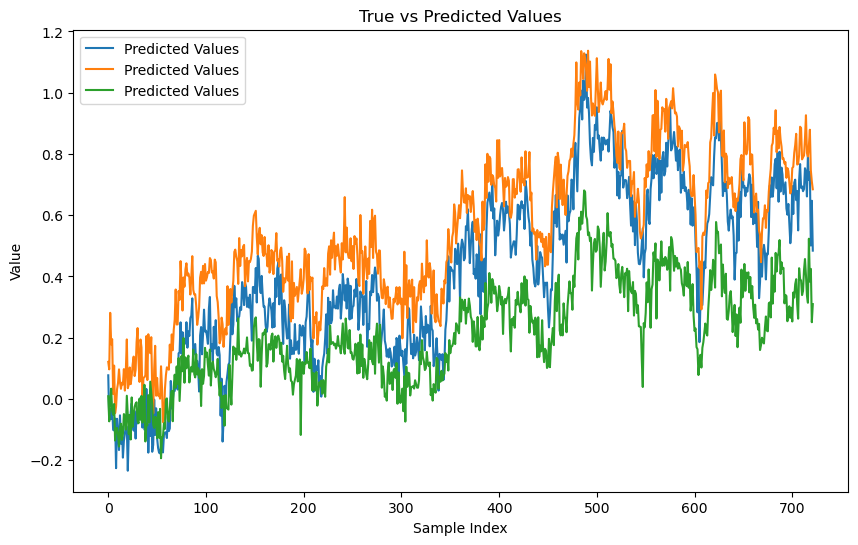

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()

In [386]:
def predict_future(model, initial_input, n_steps, look_back):
    future_predictions = []
    current_input = initial_input.clone()  # Start with the last known data

    for _ in range(n_steps):
        # Reshape current_input to match model input requirements (1, look_back, input_features)
        input_for_model = current_input.unsqueeze(0)
        
        # Predict the next value
        with torch.no_grad():
            next_prediction = model.module_(input_for_model)[0, 0].item()  # Take the scalar value from output
        
        # Append the prediction to the future predictions list
        future_predictions.append(next_prediction)
        
        # Update the current input by shifting and appending the new prediction
        next_prediction_tensor = torch.tensor([[next_prediction]], dtype=torch.float32, device='cpu').view(1, -1)

        # Concat next prediction to current input
        current_input = torch.cat((current_input[1:], next_prediction_tensor), dim=0)
    
    return future_predictions
    

# Take the last `look_back` days from X_test as the starting input
look_back = 7  # Example look_back value
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device='cpu')
last_known_data = X_test_tensor[-1]  # Last known sequence (shape: look_back x input_features)
last_date = test_residuals_df.index[-1]

# Predict the next 7 days
future_steps = 30
future_predictions = predict_future(best_model, last_known_data, future_steps, look_back)

In [387]:
# inverse transform
flat_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Extract last SARIMA-GARCH prediction value in test_residuals_df
last_sarima_garch_prediction = test_residuals_df["SARIMA-GARCH Prediction"].iloc[-1]

final_forecast = []

for i in range(len(flat_predictions)):
    final_forecast.append(last_sarima_garch_prediction + flat_predictions[i])

# Undo log-transform 
final_forecast_org = np.exp(final_forecast) - 1

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(final_forecast_org))

# Create the DataFrame
df_predictions = pd.DataFrame({
    "Predicted Values": final_forecast_org
}, index=future_dates)

# Rename the index to 'Day' for clarity
df_predictions.index.name = "Date"

# Print the DataFrame
df_predictions

# Save the DataFrame to a CSV file (optional)
# df_predictions.to_csv("future_predictions.csv", index=False)

,Predicted Values
Date,
2024-11-17 00:00:00+00:00,81451.791568
2024-11-18 00:00:00+00:00,81836.295149
2024-11-19 00:00:00+00:00,81938.815494
2024-11-20 00:00:00+00:00,81906.702331
2024-11-21 00:00:00+00:00,81931.377394
2024-11-22 00:00:00+00:00,82374.399841
2024-11-23 00:00:00+00:00,82907.920478
2024-11-24 00:00:00+00:00,83394.869973
2024-11-25 00:00:00+00:00,83870.414456


In [388]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
test_actual_org = np.exp(test_pca_df["btc_close"]) - 1

# Load test prediction npy
# test_pred = np.load('../results/predictions/test/lookback7/tft_predictions.npy')
test_arima_garch_pred = test_residuals_df["SARIMA-GARCH Prediction"]
final_test_pred = test_arima_garch_pred.iloc[look_back:].values.reshape(-1,1) + test_pred.reshape(-1,1)
final_test_pred_org = np.exp(final_test_pred) - 1

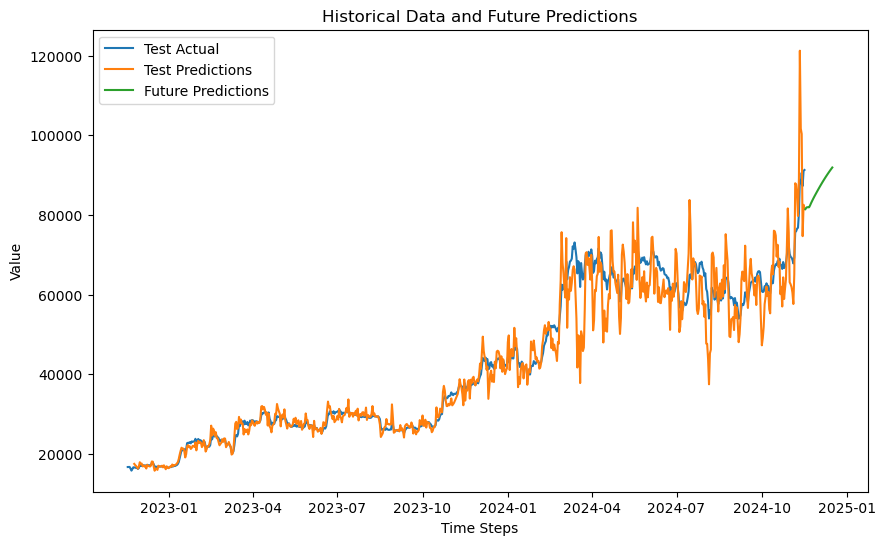

In [389]:
plt.figure(figsize=(10, 6))
plt.plot(test_pca_df.index, test_actual_org, label="Test Actual")
plt.plot(test_pca_df.index[look_back:], final_test_pred_org, label="Test Predictions")
plt.plot(df_predictions.index, df_predictions, label="Future Predictions")
plt.legend()
plt.title("Historical Data and Future Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()